In [69]:
using Interpolations
using ProfileView
using ForwardDiff
using PyPlot
using FixedSizeArrays

In [70]:
include("Acrobots/src/Acrobots.jl")

Acrobots

In [316]:
xdes = Acrobots.DoubleIntegratorState{Float64}(1, 0)
x0 = Acrobots.DoubleIntegratorState{Float64}([0; 0])
state = x0
robot = Acrobots.double_integrator()
input = Acrobots.DoubleIntegratorInput{Float64}(0)
dt = 0.001
vis = Acrobots.DrakeVisualizer(robot)
ts = 0:dt:2
Qf = diagm([1.,1])
Rf = 1e-6*eye(1)
Qt = diagm([0, 0.])

function cost(state::Acrobots.DoubleIntegratorState)
    x = convert(Vector, state - xdes)
    return 0.5*(x' * Qt * x)[1]
end
Q_generator = ForwardDiff.hessian(x -> cost(Acrobots.DoubleIntegratorState(x)), ForwardDiff.AllResults)

function cost(input::Acrobots.DoubleIntegratorInput)
    return Rf[1,1] * 0.5*input.u^2
end
R_generator = ForwardDiff.hessian(x -> cost(Acrobots.DoubleIntegratorInput(x)), ForwardDiff.AllResults)

sys_tf = Acrobots.linearize(robot, 0, xdes, input)
# S_final = Mat(Acrobots.care(convert(Matrix, sys_tf.A), convert(Matrix, sys_tf.B), Qf, Rf))
S_final = Mat(Qf)

Qs = Mat{2, 2, Float64}[]
Rs = Mat{1, 1, Float64}[]
qs = Vec{2, Float64}[]
rs = Vec{1, Float64}[]

controller_state = Acrobots.LQRState{Float64}(())
linear_sys = Acrobots.linearize(robot, 0, x0, input)
controller = Acrobots.lqr(linear_sys, Qf, Rf, x0)
linearizations = typeof(linear_sys)[]

Profile.clear()
elapsed = @elapsed for (i, t) in enumerate(ts)
    output = Acrobots.output(robot, t, state, input)
    input = Acrobots.output(controller, t, controller_state, output)
    statedot = Acrobots.dynamics(robot, t, state, input)
    state += statedot * dt
    push!(linearizations, Acrobots.linearize(robot, t, state, input))
    
    Q, Q_results = Q_generator(convert(Vector, state))
    push!(Qs, Q)
    push!(qs, ForwardDiff.gradient(Q_results))
    R, R_results = R_generator(convert(Vector, input))
    push!(Rs, R)
    push!(rs, ForwardDiff.gradient(R_results))
    
#     if mod(i, 10) == 0
        Acrobots.draw(vis, state)
#     end
end
@show elapsed / length(ts) * 1e6
# ProfileView.view()

(elapsed / length(ts)) * 1.0e6 = 598.9343808095952

598.9343808095952

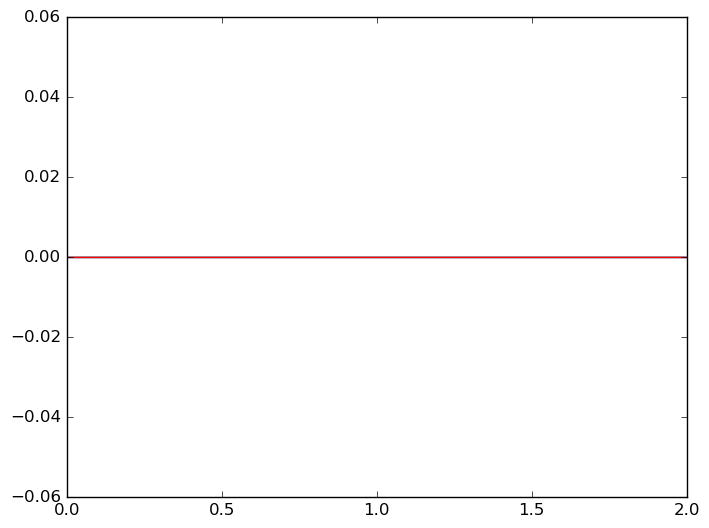

3-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa486568450>
 PyObject <matplotlib.lines.Line2D object at 0x7fa486568750>
 PyObject <matplotlib.lines.Line2D object at 0x7fa48637a6d0>

In [317]:
plot(ts, [lin.x0[1] for lin in linearizations], ts, [lin.x0[2] for lin in linearizations],
ts, [lin.u0[1] for lin in linearizations])

In [318]:
linearizations[end].x0

Acrobots.DoubleIntegratorState{Float64}(0.0,0.0)

In [319]:
alpha = 1

for i = 1:10

    Ps = Array{Mat{2, 2, Float64}}(length(ts))
    ps = Array{Vec{2, Float64}}(length(ts))
    Ks = Array{Mat{1, 2, Float64}}(length(ts))
    ls = Array{Vec{1, Float64}}(length(ts))
    As = [Mat(eye(2)) + dt * sys.A for sys in linearizations]
    Bs = [dt * sys.B for sys in linearizations]

    Ps[end] = S_final
    ps[end] = S_final * (linearizations[end].x0 - xdes)

    for j = (length(ts)-1):-1:1
        g = rs[j] + Bs[j]' * ps[j+1]
        G = Bs[j]' * Ps[j+1] * As[j]
        H = Rs[j] + Bs[j]' * Ps[j+1] * Bs[j]
        Hi = inv(H)
        Ks[j] = -Hi * G
        ls[j] = -Hi * g

        Ps[j] = Qs[j] + As[j]' * Ps[j+1] * As[j] + Ks[j]' * H * Ks[j] + Ks[j]' * G + G' * Ks[j]
        ps[j] = qs[j] + As[j]' * ps[j+1] + Ks[j]' * H * ls[j] + Ks[j]' * g + G' * ls[j]
    end
    Ks[end] = 0
    ls[end] = 0

    controllers = [Acrobots.AffineSystem(
        Mat{0,0,Float64}(),
        Mat{0,2,Float64}(),
        Mat{1,0,Float64}(),
        Mat{1,2,Float64}(Ks[j]),
        Acrobots.LQRState{Float64}(),
        Acrobots.DoubleIntegratorOutput{Float64}(linearizations[j].x0),
#         Acrobots.DoubleIntegratorOutput{Float64}(xdes),
        Acrobots.LQRState{Float64}(),
        Acrobots.DoubleIntegratorInput{Float64}(linearizations[j].u0) + Acrobots.DoubleIntegratorInput{Float64}(alpha * ls[j])) 
        for j in 1:length(ts)]


    state = x0
    input = Acrobots.AcrobotInput{Float64}(0)
    empty!(linearizations)
    empty!(Qs)
    empty!(Rs)
    empty!(qs)
    empty!(rs)

    @time for (i, t) in enumerate(ts)
        output = Acrobots.output(robot, t, state, input)
        input = Acrobots.output(controllers[i], t, controller_state, output)
        statedot = Acrobots.dynamics(robot, t, state, input)
        state += statedot * dt
        push!(linearizations, Acrobots.linearize(robot, t, state, input))

        Q, Q_results = Q_generator(convert(Vector, state))
        push!(Qs, Q)
        push!(qs, ForwardDiff.gradient(Q_results))
        R, R_results = R_generator(convert(Vector, input))
        push!(Rs, R)
        push!(rs, ForwardDiff.gradient(R_results))

#         if mod(i, 10) == 0
            Acrobots.draw(vis, state)
#         end
    end
    
end

  1.151489 seconds (857.88 k allocations: 37.195 MB, 2.07% gc time)
  1.157672 seconds (859.30 k allocations: 37.305 MB, 2.00% gc time)
  1.142643 seconds (859.76 k allocations: 37.357 MB, 1.98% gc time)
  1.150471 seconds (859.78 k allocations: 37.357 MB, 1.96% gc time)
  1.250119 seconds (855.75 k allocations: 37.118 MB, 0.96% gc time)
  1.136100 seconds (857.15 k allocations: 37.317 MB, 1.03% gc time)
  1.146395 seconds (856.66 k allocations: 37.309 MB, 0.99% gc time)
  1.157893 seconds (858.46 k allocations: 37.204 MB, 2.04% gc time)
  1.148705 seconds (859.15 k allocations: 37.303 MB, 2.03% gc time)
  

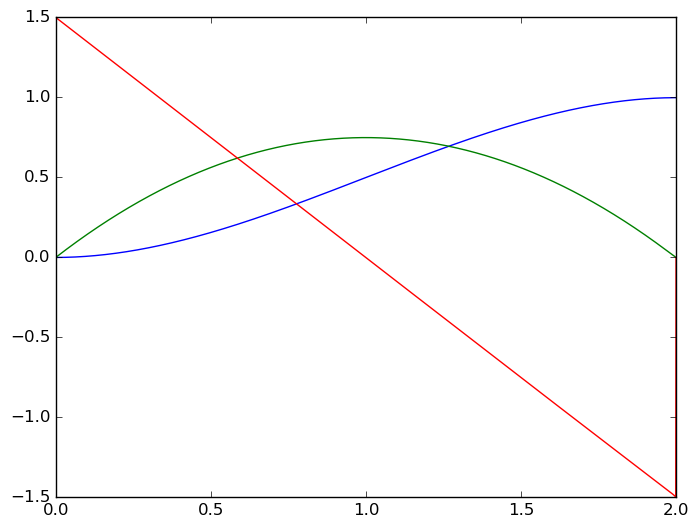

3-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa48626e210>
 PyObject <matplotlib.lines.Line2D object at 0x7fa4863580d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fa486294650>

In [321]:
plot(ts, [lin.x0[1] for lin in linearizations], ts, [lin.x0[2] for lin in linearizations],
ts, [lin.u0[1] for lin in linearizations])